In [1]:
# 
# notebook setup
#
try:
    %matplotlib nbagg
    import matplotlib.pyplot as plt
    #
    # Temporary hack needed to make the gridtools package visible from the notebook.
    # No longer needed when GT4Py will be installed as a regular Python package (i.e. through  setup.py)
    #
    import os
    os.chdir(os.path.abspath('..'))
except Exception:
    print ("### WARNING: plotting not available")
else:
    import numpy as np
    print ("Plotting enabled")

Plotting enabled


# ::: Gridtools4Py :::
## A Python interface for Gridtools

### Game of Life in MATLAB and Python

In [2]:
from gridtools.stencil import Stencil


@Stencil.kernel
def game_of_life (out_X, in_X):
    for p in Stencil.get_interior_points (out_X):
        Y = in_X[p + (1,0,0)]  + in_X[p + (1,1,0)]   + \
            in_X[p + (0,1,0)]  + in_X[p + (-1,1,0)]  + \
            in_X[p + (-1,0,0)] + in_X[p + (-1,-1,0)] + \
            in_X[p + (0,-1,0)] + in_X[p + (1,-1,0)]

        out_X[p] = (in_X[p] and (Y == 2)) or (Y == 3)


# Generate a random initial population
domain = (50, 50, 4)
in_X = np.zeros(domain)
in_X[19:33,19:33,:] = np.random.rand(14,14,4) > .75
out_X = np.copy(in_X)

# Set stencil options
Stencil.set_halo( (1,1,1,1) )

### Run the stencil in Python mode

In [3]:
Stencil.set_backend ("python")

%timeit -n1 -p3 -r 10 game_of_life (out_X=out_X, in_X=in_X) # execute it

1 loop, best of 10: 173 ms per loop


### Run the *same* stencil in C++ mode

In [4]:
Stencil.set_backend ("c++")                   # will run using GridTools

%timeit -n1 -p3 -r 10 game_of_life (out_X=out_X, in_X=in_X) # execute it

The slowest run took 67601.95 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 10: 95.1 µs per loop


## What just happened?

### The code has been translated, compiled and dynamically linked into *this* notebook

In [5]:
Stencil.compiler.lib_handle

<CDLL '/tmp/__gridtools_0m80p6uu/libgridtools4py.0001.so', handle 350e0c0 at 7fa3a1709fd0>

### OOP example: the Laplace operator

In [6]:
from gridtools.stencil import MultiStageStencil

class Laplace (MultiStageStencil):
    def __init__ (self):
        super ( ).__init__ ( )
        
    @Stencil.kernel
    def kernel (self, out_data, in_data):
        for p in self.get_interior_points (out_data):
            out_data[p] = -4.0 * in_data[p] - (
                          in_data[p + (1,0,0)]  + in_data[p + (0,1,0)] + 
                          in_data[p + (-1,0,0)] + in_data[p + (0,-1,0)])

### Use NumPy arrays as data fields

In [7]:
domain = (64, 64, 32)

source = np.random.rand (*domain)   # data field of size 'domain'
                                    # filled with random numbers
target = np.zeros (domain)          # data field of size 'domain'
                                    # filled with zeros

### Run it in Python, C++ and CUDA modes

In [8]:
lap = Laplace ( )
lap.set_halo        ( (1, 1, 1, 1) )
lap.set_k_direction ("forward")

lap.set_backend ('python')
%timeit -n 1 -p 3 -r 5 lap.run (in_data=source, out_data=target)

#lap.backend = "cuda"
#%timeit -n 1 -p 3 -r 5 lap.run (in_data=source, out_data=target)

lap.set_backend ('c++')
%timeit -n 1 -p 3 -r 5 lap.run (in_data=source, out_data=target)

1 loop, best of 5: 1.01 s per loop
The slowest run took 22449.31 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 214 µs per loop


### Matplotlib integration: creating graphs

In [9]:
from tests.test_stencils import HorizontalDiffusion

#
# initialize the input data
#
for i in range (domain[0]):
    for j in range (domain[1]):
        for k in range (domain[2]):
            source[i,j,k] = i**5 + j
wgt    = np.ones (domain)
target = np.ones (domain)

hd = HorizontalDiffusion (domain)
hd.set_halo ( (2,2,2,2) )
hd.run (out_data=target,
        in_wgt=wgt,
        in_data=source)

<IPython.core.display.Javascript object>


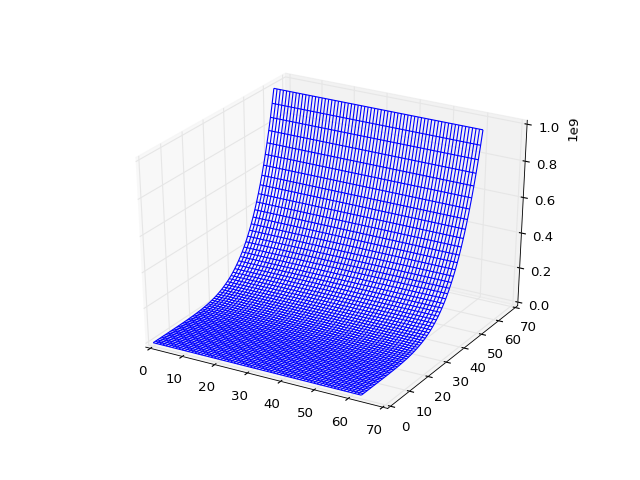

<IPython.core.display.Javascript object>


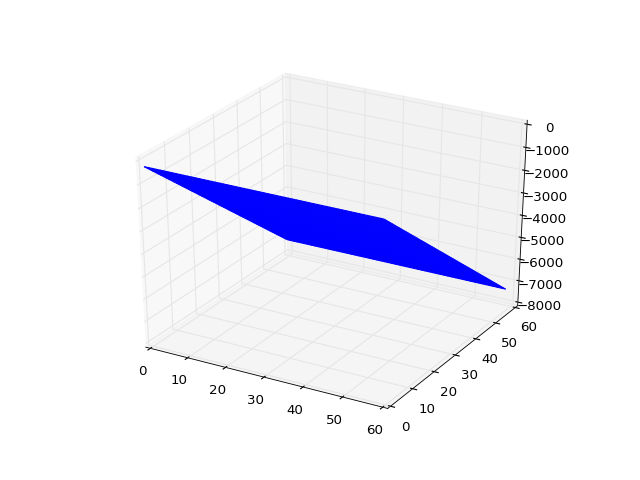

In [10]:
hd.plot_3d (source[:,:,0])
hd.plot_3d (target[2:-2,2:-2,0])

### Stage execution path and data-dependency graph

<IPython.core.display.Javascript object>


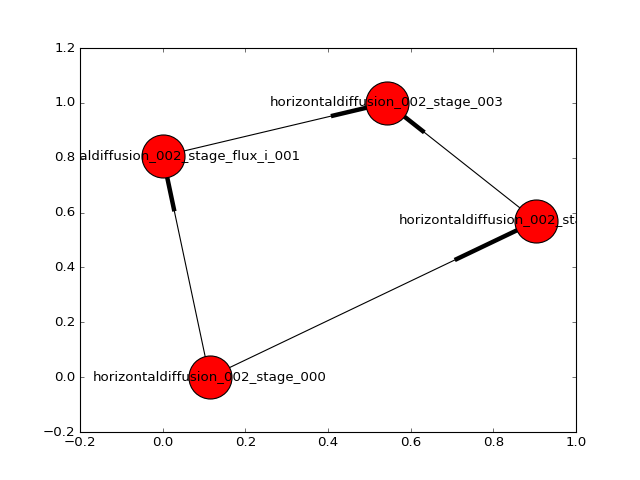

In [11]:
hd.plot_stage_execution ( )

<IPython.core.display.Javascript object>


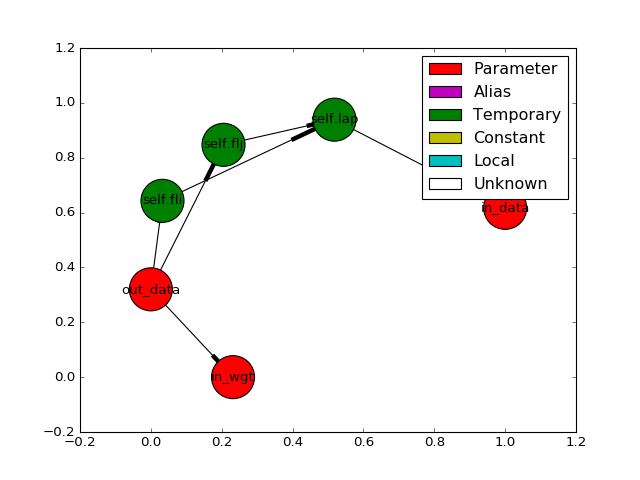

In [12]:
hd.plot_data_dependency (show_legend=True)

## Matplotlib integration: creating animations

<IPython.core.display.Javascript object>


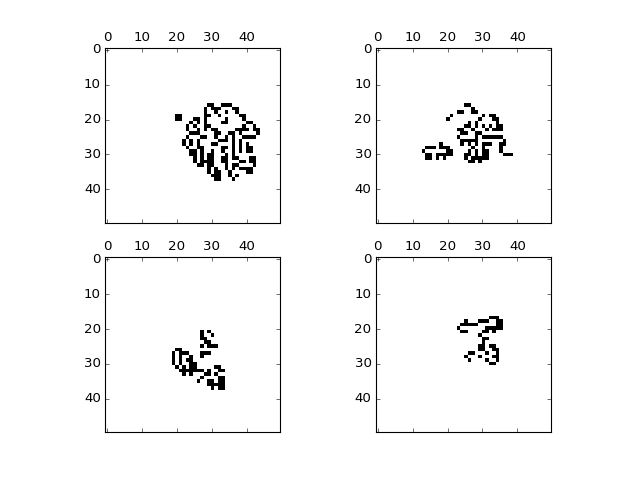

In [13]:
import matplotlib.animation as animation

fig = plt.figure ( )
ax0 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

im0  = ax0.spy (in_X[:,:,0])
im1  = ax1.spy (in_X[:,:,1])
im2  = ax2.spy (in_X[:,:,2])
im3  = ax3.spy (in_X[:,:,3])

def anim_init ( ):
    im0.set_data (in_X[:,:,0])
    im1.set_data (in_X[:,:,1])
    im2.set_data (in_X[:,:,2])
    im3.set_data (in_X[:,:,3])
    return [im0,im1,im2,im3]

def anim_frame (i):
    global out_X, in_X
    game_of_life (out_X=out_X, in_X=in_X)
    if i%2 == 0:
        im0.set_data (in_X[:,:,0])
        im1.set_data (in_X[:,:,1])
        im2.set_data (in_X[:,:,2])
        im3.set_data (in_X[:,:,3])
    in_X = out_X
    return [im0,im1,im2,im3]

anim = animation.FuncAnimation (fig,
                                anim_frame,
                                init_func=anim_init,
                                frames=200,
                                interval=100,
                                blit=True)

In [14]:
from tests.test_sw import LocalSWTest

sw = LocalSWTest()
sw.setUp()
sw.test_animation (50000)

### Performance comparison (pure C++ <--> Python with C++ backend) 

```
* Copy                 11342 FPS <--> 6710 FPS (~39% overhead)
* Laplace               4276 FPS <--> 3732 FPS (~13% overhead)
* Horizontal diffusion   633 FPS <-->  550 FPS (~13% overhead)
* Shallow water         2710 FPS <--> 2525 FPS (~7% overhead)
```

#### The constant overhead is on the Python side due to library and parameter handling